In [ ]:
# Titanic Competition: https://www.kaggle.com/competitions/titanic/data
import pandas as pd
import seaborn as sns

train = pd.read_csv('Dados/titanic/train.csv')
test = pd.read_csv('Dados/titanic/test.csv')

In [ ]:
train = train.set_index('PassengerId')
test = test.set_index('PassengerId')

train.shape, test.shape
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [3]:
# To complete the cabin, lets suppose that the family was in same cabin.
    
nan_cabin_passenger = train.loc[train['Cabin'].isnull() 
                                & train['travel_with_family'] == 1][
                                ['Surname', 'travel_with_family', 'Name', 'Cabin']
                                ]
cabin_family = train.loc[~train['Cabin'].isnull() & train['Surname'].isin(nan_cabin_passenger['Surname'])][['Name', 'Surname', 'Cabin']]
mapping_surname_cabin = cabin_family.drop_duplicates('Surname')
mapping_surname_cabin = mapping_surname_cabin.set_index('Surname')['Cabin']
train['Cabin'] = train['Cabin'].fillna(train['Surname'].map(mapping_surname_cabin))

In [4]:
# Dealing with miss values about cabin and encoding the cabin
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

cabins_letter = train['Cabin'].astype(str).str.replace(r'[^a-zA-Z]', '', regex=True).str.split()
def choose_random(val):
    if 'nan' in val or '' in val:
        return 'U'
    
    if len(val) > 1:
        choice = np.random.choice(val)
        if len(choice) > 1:
            return choice[0]
            
        return choice
    if len(val[0]) > 1:
        return val[0][0]
        
    return val[0]

cabins_letter = cabins_letter.apply(choose_random)
train['Cabin'] = cabins_letter

cabins_letter_test = test['Cabin'].astype(str).str.replace(r'[^a-zA-Z]', '', regex=True).str.split()
cabins_letter_test = cabins_letter_test.apply(choose_random)
test['Cabin'] = cabins_letter_test

# enc = OrdinalEncoder()
# cabin_enc = enc.fit_transform(train[['Cabin']])
# train['Cabin'] = cabin_enc[:, 0]

# cabin_enc_test = enc.transform(test[['Cabin']])
# test['Cabin'] = cabin_enc_test[:, 0]

# le = LabelEncoder()
# train['Cabin'] = le.fit_transform(train['Cabin'])
# test['Cabin'] = le.transform(test['Cabin'])

ohe_cab = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

cabin_ohe_train = ohe_cab.fit_transform(train[['Cabin']])
cabin_ohe_test = ohe_cab.transform(test[['Cabin']])

train = pd.concat([train.drop(columns=['Cabin']), cabin_ohe_train], axis=1)
test = pd.concat([test.drop(columns=['Cabin']), cabin_ohe_test], axis=1)

train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,title_Rare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
# Dealing with the missing values about embarked.
# I will put the mathematical mode.

mode_train = train['Embarked'].value_counts()
train['Embarked'] = train['Embarked'].fillna('S')

# Encoding "Embarked" 
map_embarked = {'S': 0, 'C': 1, 'Q': 2}
train['Embarked'] = train['Embarked'].map(map_embarked)
test['Embarked'] = test['Embarked'].map(map_embarked)

In [6]:
train['Sex'] = train['Sex'].replace(to_replace=['male', 'female'], value=[0, 1])
test['Sex'] = test['Sex'].replace(to_replace=['male', 'female'], value=[0, 1])

/tmp/ipykernel_93032/4184202167.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['Sex'] = train['Sex'].replace(to_replace=['male', 'female'], value=[0, 1])
/tmp/ipykernel_93032/4184202167.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Sex'] = test['Sex'].replace(to_replace=['male', 'female'], value=[0, 1])


In [7]:
#The 'ticket' column contains string data. The authors suggest using an encoding method for this data type. I am applying the Feature Hashing method,
#as described in Feature Engineering and Selection by Max Kuhn and Kjell Johnson

from sklearn.feature_extraction import FeatureHasher

features = 2**2
# features = 3

h = FeatureHasher(n_features=features, input_type='string')
ticket_proc = train['Ticket'].astype(str).str.replace('/', ' ', regex=False).str.replace(r'[^\w\s]', '', regex=True).str.split()
ticket_feat_hasher = h.fit_transform(ticket_proc).toarray()
ticket_feat_hasher_df = pd.DataFrame(ticket_feat_hasher, columns = [f'f{i}' for i in range(len(ticket_feat_hasher[0]))], index = train.index)
train = pd.concat([train, ticket_feat_hasher_df], axis=1)
train = train.drop(columns = ['Ticket'])


ticket_proc = test['Ticket'].astype(str).str.replace('/', ' ', regex=False).str.replace(r'[^\w\s]', '', regex=True).str.split()
ticket_feat_hasher = h.transform(ticket_proc).toarray()
ticket_feat_hasher_df = pd.DataFrame(ticket_feat_hasher, columns = [f'f{i}' for i in range(len(ticket_feat_hasher[0]))], index = test.index)
test = pd.concat([test, ticket_feat_hasher_df], axis=1)
test = test.drop(columns = ['Ticket'])



In [8]:
train['Age'].isna().sum() / train['Age'].isna().count() # 20% unknow, 80% know. Remove the unknow data is not appropriate

# Solution: Impute data with KNN. Source: Feature Engineering and Selection by Max Kuhn and Kjell Johnson
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

df_aux = train.select_dtypes(include = ['number'])

corr = df_aux.corr()['Age']
corr_abs = 0.15
corr_age_feat = corr[abs(corr) > corr_abs].index
# corr[abs(corr) > corr_abs], corr_age_feat

imputer = KNNImputer(n_neighbors=3)
data_to_impute = train[corr_age_feat]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_impute)

imputer_df_pred = imputer.fit_transform(data_scaled) # KNN
imputed_data_final = scaler.inverse_transform(imputer_df_pred) # Return to normal scale

df_aux_train = pd.DataFrame(imputed_data_final, columns = corr_age_feat, index=train.index)

train['Age'] = df_aux_train['Age']


data_to_impute_test = test[corr_age_feat]
data_scaled_test = scaler.transform(data_to_impute_test)
imputer_df_pred_test = imputer.transform(data_scaled_test) # KNN
imputed_data_final_test = scaler.inverse_transform(imputer_df_pred_test) # Return to normal scale
df_aux_test = pd.DataFrame(imputed_data_final_test, columns = corr_age_feat, index=test.index)
test['Age'] = df_aux_test['Age']

In [9]:
test = test.drop(columns=['Name', 'Surname'])
train = train.drop(columns=['Name', 'Surname'])

In [10]:
train.corr()
# train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,size_family,travel_with_family,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,f0,f1,f2,f3
Survived,1.000000,-0.338481,0.543351,-0.127442,-0.035322,0.081629,0.257307,0.106811,-0.049188,0.061081,...,0.149277,0.124908,0.067294,0.016040,-0.026456,-0.303333,-0.012780,-0.047809,-0.103685,0.095699
Pclass,-0.338481,1.000000,-0.131900,-0.275812,0.083081,0.018443,-0.549500,0.045702,0.113262,0.015938,...,-0.275194,-0.191334,0.018134,0.055561,-0.052496,0.700137,0.047504,0.121631,0.119625,-0.045349
Sex,0.543351,-0.131900,1.000000,-0.173348,0.114631,0.245489,0.182333,0.116569,0.118485,0.159114,...,0.080610,0.023089,0.020142,0.091031,-0.024728,-0.130294,-0.108114,-0.025900,-0.080063,-0.038195
Age,-0.127442,-0.275812,-0.173348,1.000000,-0.347147,-0.244817,0.040638,0.018885,-0.297834,-0.296868,...,0.088409,0.086407,-0.096819,-0.073719,0.032065,-0.175360,0.002489,-0.017523,-0.016556,0.035661
SibSp,-0.035322,0.083081,0.114631,-0.347147,1.000000,0.414838,0.159651,-0.059961,0.667568,0.459853,...,-0.022568,-0.047732,-0.002638,-0.001402,-0.015907,0.052003,-0.082275,-0.035777,0.004214,-0.034967
Parch,0.081629,0.018443,0.245489,-0.244817,0.414838,1.000000,0.216225,-0.078665,0.600538,0.459911,...,-0.009723,-0.028763,0.040975,0.072388,-0.015878,-0.033793,-0.163763,-0.020084,0.037530,-0.037095
Fare,0.257307,-0.549500,0.182333,0.040638,0.159651,0.216225,1.000000,0.062142,0.105880,0.134850,...,0.096308,0.036195,-0.033697,-0.025180,0.002224,-0.459901,-0.064653,-0.185134,-0.069077,0.007414
Embarked,0.106811,0.045702,0.116569,0.018885,-0.059961,-0.078665,0.062142,1.000000,-0.066585,-0.018086,...,0.003195,0.014420,-0.015050,-0.038199,-0.019067,-0.032774,-0.054536,-0.026431,-0.134219,-0.050148
size_family,-0.049188,0.113262,0.118485,-0.297834,0.667568,0.600538,0.105880,-0.066585,1.000000,0.725468,...,-0.030594,-0.032682,0.003943,0.005321,-0.019883,-0.000691,-0.105734,-0.035519,-0.038026,-0.071508
travel_with_family,0.061081,0.015938,0.159114,-0.296868,0.459853,0.459911,0.134850,-0.018086,0.725468,1.000000,...,-0.023857,0.036450,0.044026,0.082131,-0.027407,-0.106904,-0.142385,-0.013318,-0.011387,0.016501


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE


rfc = RandomForestClassifier(max_depth=500)
abc = AdaBoostClassifier(n_estimators = 5)
gbc = GradientBoostingClassifier(n_estimators = 10)

y = train['Survived']
train = train.drop(columns=['Survived'])

sm = SMOTE(random_state=42)
X, y_res = sm.fit_resample(train, y)
X.shape, y_res.shape

((1098, 27), (1098,))

In [21]:
rfc_cvs = cross_val_score(rfc, X, y_res, cv=5)
print(f"Acurácia média: {rfc_cvs.mean()}")

Acurácia média: 0.8516770444167705


In [13]:
abc_cvs = cross_val_score(abc, X, y_res, cv=5)
print(f"Acurácia média: {abc_cvs.mean()}")

Acurácia média: 0.7924408468244085


In [14]:
gbc_cvs = cross_val_score(gbc, X, y_res, cv=5)
print(f"Acurácia média: {gbc_cvs.mean()}")


Acurácia média: 0.8352511415525115


In [20]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)
best_score = 0
save_y_pred = None
save_X = None
save_y = None

for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y_res.iloc[train_idx], y_res.iloc[test_idx]

    rfc.fit(X_train_fold, y_train_fold)
    pred = rfc.predict(X_test_fold)
    score = rfc.score(X_test_fold, y_test_fold)
    
    if score > best_score:
        best_score = score
        save_y_pred = pred
        save_X = X_test_fold
        save_y = y_test_fold
best_score

ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

NameError: name 'plt' is not defined

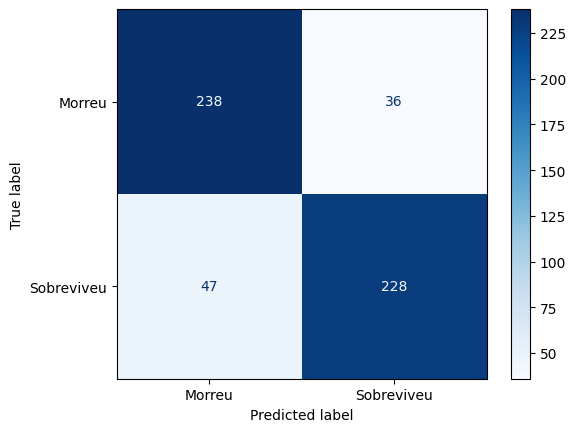

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Gera a matriz usando o melhor fold salvo
cm = confusion_matrix(save_y, save_y_pred)

# Plota de forma visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Morreu', 'Sobreviveu'])
disp.plot(cmap='Blues')
plt.title(f'Matriz de Confusão (Melhor Score: {best_score:.4f})')
plt.show()

In [16]:
y_pred = rfc.predict(test)

In [17]:
submission = pd.DataFrame({
    "PassengerId": test.index,
    "Survived": y_pred
})

submission.to_csv("submission4.csv", index=False)